In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataloader
import seq2seq
from seq2seq.models import AttentionSeq2Seq, SimpleSeq2Seq, Seq2Seq
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import CuDNNLSTM, LSTM, LeakyReLU

c:\users\deyan\tf-workspace\env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_seq_length = 288
output_seq_length = 48
X_train, Y_train, X_test, Y_test = dataloader.generate_data_keras(input_seq_length, output_seq_length)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
in_dim = X_train.shape[2] # 17
in_len = X_train.shape[1] # 864
out_dim = Y_train.shape[2] # 1
out_len = Y_train.shape[1] # 24
batch_size = 512
epochs = 2

print(in_dim, in_len, out_dim, out_len, batch_size, epochs)
#Input shape
#3D tensor with shape (batch_size, timesteps, input_dim)

(45433, 288, 17) (45433, 48, 1)
(1718, 288, 17) (1718, 48, 1)
17 288 1 48 512 2


In [3]:
model = Seq2Seq(input_dim=in_dim, input_length=in_len, hidden_dim=128, output_length=out_len, output_dim=out_dim, depth=2, dropout=0.5, peek=True)
#model = AttentionSeq2Seq(input_dim=in_dim, input_length=in_len, hidden_dim=128, output_length=out_len, output_dim=out_dim, depth=2)
#model = SimpleSeq2Seq(input_dim=in_dim, input_length=in_len, hidden_dim=128, output_length=out_len, output_dim=out_dim, depth=2)
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 288, 17)      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 288, 128)     2304        input_13[0][0]                   
__________________________________________________________________________________________________
private__optional_input_place_h (2,)                 0                                            
__________________________________________________________________________________________________
private__optional_input_place_h (2,)                 0                                            
__________________________________________________________________________________________________
private__o

In [4]:

output_file_name = 'nn_models/keras/attentionseq2seq'
model.fit(
    X_train, 
    Y_train, 
    batch_size=batch_size,
    validation_split=0.15,
    #validation_data=(validation_datas,validation_labels), 
    epochs=epochs,
    verbose=1)

Train on 38618 samples, validate on 6815 samples
Epoch 1/1
38618/38618 [==============================] - 259s 7ms/step - loss: 0.0039 - val_loss: 0.0215


In [9]:
dataloader.scaler.scale_

'17_288_1_24_512_5'

In [10]:
model_info = [in_dim, in_len, out_dim, out_len, batch_size, epochs]
joined = '_'.join(str(x) for x in model_info)
model.save('nn_models/keras/seq2seq_' + joined + '.h5')

In [15]:
import imp
imp.reload(dataloader)
X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=nb_predictions)
X.shape

(288, 5, 17)

Let's visualize 1 predictions with our signals:
(288, 1, 17) (48, 1, 1)
(1, 288, 17)
1/1 [==============================] - 0s 335ms/step
outputs_shape (1, 48, 1)


<IPython.core.display.Javascript object>


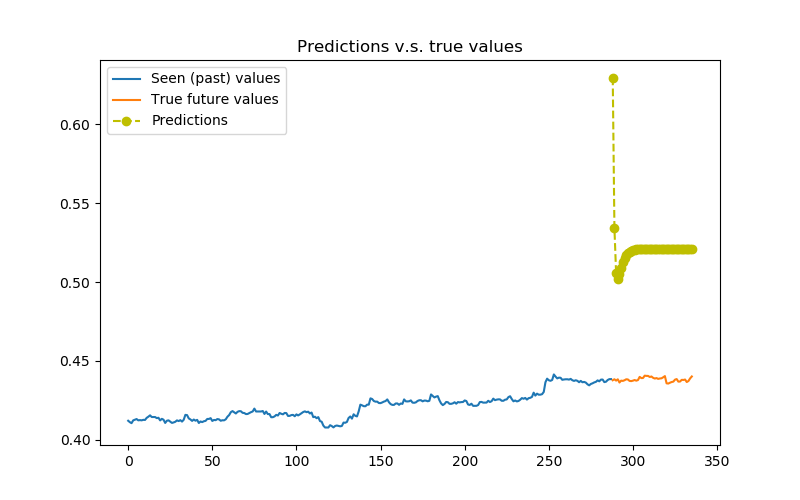

(288,) (48,) (48,)
[0.6297882  0.53422296 0.5057305  0.5021053  0.50520396 0.50918
 0.5125241  0.51503825 0.5168537  0.51814413 0.51905596 0.51969874
 0.5201513  0.52047014 0.5206945  0.5208524  0.52096355 0.5210418
 0.5210969  0.5211356  0.5211629  0.5211821  0.52119565 0.5212052
 0.52121186 0.5212165  0.52121997 0.5212223  0.5212239  0.521225
 0.5212258  0.5212264  0.5212269  0.5212271  0.52122724 0.52122736
 0.5212275  0.5212276  0.5212277  0.5212277  0.52122784 0.52122784
 0.52122784 0.52122784 0.52122784 0.52122784 0.52122784 0.52122784]
Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [23]:
# Test
nb_predictions = 1
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=nb_predictions)
print(X.shape, Y.shape)
print(X.reshape(-1,288,17).shape)
outputs = model.predict(X.reshape(-1,288,17), batch_size=5, verbose=1)
#outputs = outputs.reshape(48,-1,1)
#feed_dict = {enc_inp[t]: X[t] for t in range(input_seq_length)}
#outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
print('outputs_shape', outputs.shape)


for j in range(nb_predictions): 
    plt.figure(figsize=(8, 5))
    
    for k in range(out_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[j,:,k]
        
        print(past.shape, expected.shape, pred.shape)
        print(pred)
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

#Input shape
#3D tensor with shape (batch_size, timesteps, input_dim)